### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Cleaned1.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A' ,'e' ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
       'OMEGA', 'i0', 'Cuc','Cus','Toe', 'OMEGA_dot', 'omega',
       'Cis', 'Crc', 'I_dot', 'Del_n', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,M0,Cic
Epoch_Time_of_Clock,,
2017-11-01 14:00:00,2.75563657824999985735,-0.00000008940696716310
2017-11-01 16:00:00,-2.47738129409000018555,0.00000003352761268620
2017-11-01 18:00:00,-1.42713945816000009614,0.00000011548399925200
2017-11-01 20:00:00,-0.37692427951800006047,0.00000007636845111850
2017-11-01 22:00:00,0.67320921416299994711,-0.00000000931322574615


In [3]:
var_name = 'Cic'
sat_var = 1

In [4]:

df = df.iloc[5 : , :]

In [6]:

df.head(7)
df.columns

Index(['M0', 'Cic'], dtype='object')

# Enter number of entries per day

In [66]:
entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))

168
2017-11-25 12:00:00 2017-11-21 12:00:00
<class 'str'>



Load data into Pandas dataframe

# enter lag and no. of outputs

In [67]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 6
HORIZON = 6

Create training set containing only the model features

In [68]:
train = df.copy()[df.index < valid_start_dt][['M0', 'Cic' ]]
train.head()

,Cic
Epoch_Time_of_Clock,
2017-11-02 12:00:00,-0.00000019744038581800
2017-11-02 14:00:00,-0.00000009685754776000
2017-11-02 16:00:00,0.00000005215406417850
2017-11-02 18:00:00,0.00000014901161193800
2017-11-02 20:00:00,0.00000009313225746150


In [69]:
train.tail(6)

,Cic
Epoch_Time_of_Clock,
2017-11-20 12:00:00,-0.00000013597309589400
2017-11-20 14:00:00,-0.00000004470348358150
2017-11-20 16:00:00,0.00000003911554813390
2017-11-20 18:00:00,0.00000011920928955100
2017-11-20 20:00:00,0.00000004842877388000
2017-11-20 22:00:00,-0.00000005215406417850


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [70]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[['M0', 'Cic']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [71]:
tensor_structure = {'X':(range(-T+1, 1), ['M0', 'Cic'])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), ['M0', 'Cic'])} ,freq = None)

In [72]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 22:00:00 -1.85870520714937992324 -0.69207806647229008767   
2017-11-03 12:00:00 -0.69207806647229008767  0.69890044741128376504   
2017-11-03 14:00:00  0.69890044741128376504  1.46169511631204485091   
2017-11-03 16:00:00  1.46169511631204485091  0.81855451311808957726   
2017-11-03 18:00:00  0.81855451311808957726 -0.43781317683709725097   
2017-11-03 20:00:00 -0.43781317683709725097 -1.99331603107294919042   
2017-11-03 22:00:00 -1.99331603107294919042 -0.51259696790646047670   
2017-11-04 12:00:00 -0.51259696790646047670  0.96812209526163417461   
2017-11-04 14:00:00  0.96812209526163417461  1.58134918202366869799   
2017-11-04 16:00:00  1.58134918202366869799  0.72881396383918972681   
2017-11-04 18:00:00  0.72881396383918972681 -0.79677537396474151787   
2017-11-04 20:00:00 -0.79677537396474151787 -1.91853224000519229087   
2017-11-04 22:00:00 -1.91853224000519229087 -0.31815911112707939701   
2017-11-05 12:00:00 -0.31815911112707939701  1.07281940275328269152   
2017-11-05 14:00:00  1.07281940275328269152  1.53647890738783221565   
2017-11-05 16:00:00  1.53647890738783221565  0.56428962348691147355   
2017-11-05 18:00:00  0.56428962348691147355 -1.08095378003185538240   
2017-11-05 20:00:00 -1.08095378003185538240 -1.72409438322581087810   
2017-11-05 22:00:00 -1.72409438322581087810 -0.24337532005771611576   
2017-11-06 12:00:00 -0.24337532005771611576  0.93820857882971331332   
2017-11-06 14:00:00  0.93820857882971331332  1.44673835810009943081   
2017-11-06 16:00:00  1.44673835810009943081  0.44463555777689361959   
2017-11-06 18:00:00  0.44463555777689361959 -1.11086729645574644465   
2017-11-06 20:00:00 -1.11086729645574644465 -1.55957004287032052758   
2017-11-06 22:00:00 -1.55957004287032052758 -0.31815911112707939701   
2017-11-07 12:00:00 -0.31815911112707939701  0.68394368919773218529   
2017-11-07 14:00:00  0.68394368919773218529  1.46169511631204485091   
2017-11-07 16:00:00  1.46169511631204485091  0.47454907420479952584   
2017-11-07 18:00:00  0.47454907420479952584 -0.91642943967636536495   
2017-11-07 20:00:00 -0.91642943967636536495 -1.52965652644642968738   
...                                     ...                     ...   
2017-11-15 12:00:00 -0.28824559469917349075  0.74377072205274119554   
2017-11-15 14:00:00  0.74377072205274119554  1.05786264454133704938   
2017-11-15 16:00:00  1.05786264454133704938  0.35489500849397881410   
2017-11-15 18:00:00  0.35489500849397881410 -0.39294290219563982047   
2017-11-15 20:00:00 -0.39294290219563982047 -1.18565108752350378829   
2017-11-15 22:00:00 -1.18565108752350378829 -0.24337532005771611576   
2017-11-16 12:00:00 -0.24337532005771611576  0.56428962348691147355   
2017-11-16 14:00:00  0.56428962348691147355  0.95316533704968864349   
2017-11-16 16:00:00  0.95316533704968864349  0.39976528313543618909   
2017-11-16 18:00:00  0.39976528313543618909 -0.24337532005771611576   
2017-11-16 20:00:00 -0.24337532005771611576 -1.08095378003185538240   
2017-11-16 22:00:00 -1.08095378003185538240 -0.25833207827207055329   
2017-11-17 12:00:00 -0.25833207827207055329  0.38480852492188477587   
2017-11-17 14:00:00  0.38480852492188477587  0.93820857882971331332   
2017-11-17 16:00:00  0.93820857882971331332  0.45959231599044514383   
2017-11-17 18:00:00  0.45959231599044514383 -0.16859152898915566454   
2017-11-17 20:00:00 -0.16859152898915566454 -1.06599702181990996230   
2017-11-17 22:00:00 -1.06599702181990996230 -0.31815911112707939701   
2017-11-18 12:00:00 -0.31815911112707939701  0.28011121742541844615   
2017-11-18 14:00:00  0.28011121742541844615  0.95316533704968864349   
2017-11-18 16:00:00  0.95316533704968864349  0.50446259063190257432   
2017-11-18 18:00:00  0.5

In [73]:
train_inputs['target'].shape

(103, 6)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [74]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][['M0', 'Cic']]
valid[['M0', 'Cic']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -0.88651592325247430271 -0.12372125434769827568   
2017-11-22 12:00:00 -0.12372125434769827568  0.57924638170126596659   
2017-11-22 14:00:00  0.57924638170126596659  0.83351127133806490743   
2017-11-22 16:00:00  0.83351127133806490743  0.13054363528669174488   
2017-11-22 18:00:00  0.13054363528669174488 -0.57242400076146948695   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00  0.57924638170126596659  0.83351127133806490743   
2017-11-22 12:00:00  0.83351127133806490743  0.13054363528669174488   
2017-11-22 14:00:00  0.13054363528669174488 -0.57242400076146948695   
2017-11-22 16:00:00 -0.57242400076146948695 -0.72199158289939313615   
2017-11-22 18:00:00 -0.72199158289939313615  0.04080308600425872068   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00  0.13054363528669174488 -0.57242400076146948695   
2017-11-22 12:00:00 -0.57242400076146948695 -0.72199158289939313615   
2017-11-22 14:00:00 -0.72199158289939313615  0.04080308600425872068   
2017-11-22 16:00:00  0.04080308600425872068  0.66898693098418071656   
2017-11-22 18:00:00  0.66898693098418071656  0.71385720562563814706   

tensor                                    X                          \
feature                                 Cic                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.02112674717604368091 -0.27328883648562202202   
2017-11-22 12:00:00 -0.27328883648562202202  0.44463555777689361959   
2017-11-22 14:00:00  0.44463555777689361959  0.92325182061776778220   
2017-11-22 16:00:00  0.92325182061776778220  0.28011121742541844615   
2017-11-22 18:00:00  0.28011121742541844615 -0.51259696790646047670   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00  0.44463555777689361959  0.92325182061776778220   
2017-11-22 12:00:00  0.92325182061776778220  0.28011121742541844615   
2017-11-22 14:00:00  0.28011121742541844615 -0.51259696790646047670   
2017-11-22 16:00:00 -0.51259696790646047670 -0.88651592325247430271   
2017-11-22 18:00:00 -0.88651592325247430271 -0.12372125434769827568   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-21 22:00:00  0.28011121742541844615 -0.51259696790646047670  
2017-11-22 12:00:00 -0.51259696790646047670 -0.88651592325247430271  
2017-11-22 14:00:00 -0.88651592325247430271 -0.12372125434769827568  
2017-11-22 16:00:00 -0.12372125434769827568  0.57924638170126596659  
2017-11-22 18:00:00  0.57924638170126596659  0.83351127133806490743

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [75]:
#Image('./images/simple_encoder_decoder.png')

In [76]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [77]:
LATENT_DIM = 64
BATCH_SIZE = 8
EPOCHS = 10

In [78]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [79]:
model.compile(optimizer='RMSprop', loss='mse')

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 6, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 1)              65        
_________________________________________________________________
flatten_2 (Flatten)          (None, 6)                 0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [81]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [82]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [83]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 103 samples, validate on 13 samples
Epoch 1/10
103/103 [==============================] - 1s 14ms/step - loss: 0.9634 - val_loss: 0.2650
Epoch 2/10
103/103 [==============================] - 0s 1ms/step - loss: 0.8532 - val_loss: 0.2370
Epoch 3/10
103/103 [==============================] - 0s 2ms/step - loss: 0.7294 - val_loss: 0.2117
Epoch 4/10
103/103 [==============================] - 0s 2ms/step - loss: 0.6489 - val_loss: 0.1947
Epoch 5/10
103/103 [==============================] - 0s 2ms/step - loss: 0.6093 - val_loss: 0.1864
Epoch 6/10
103/103 [==============================] - 0s 2ms/step - loss: 0.5810 - val_loss: 0.1760
Epoch 7/10
103/103 [==============================] - 0s 2ms/step - loss: 0.5401 - val_loss: 0.1565
Epoch 8/10
103/103 [==============================] - 0s 2ms/step - loss: 0.4760 - val_loss: 0.1283
Epoch 9/10
103/103 [==============================] - 0s 2ms/step - loss: 0.3960 - val_loss: 0.0974
Epoch 10/10
103/103 [==============================] -

In [84]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

## Evaluate the model

In [26]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][[var_name]]
test[[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.45276993505145163299  0.23524094278396104341   
2017-11-26 12:00:00  0.23524094278396104341  0.65403017276982633454   
2017-11-26 14:00:00  0.65403017276982633454  0.42967879956334220637   
2017-11-26 16:00:00  0.42967879956334220637 -0.07885097970624084518   
2017-11-26 18:00:00 -0.07885097970624084518 -0.40789966040999431351   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.65403017276982633454  0.42967879956334220637   
2017-11-26 12:00:00  0.42967879956334220637 -0.07885097970624084518   
2017-11-26 14:00:00 -0.07885097970624084518 -0.40789966040999431351   
2017-11-26 16:00:00 -0.40789966040999431351 -0.52755372612001194543   
2017-11-26 18:00:00 -0.52755372612001194543  0.17541390992814917538   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.07885097970624084518 -0.40789966040999431351   
2017-11-26 12:00:00 -0.40789966040999431351 -0.52755372612001194543   
2017-11-26 14:00:00 -0.52755372612001194543  0.17541390992814917538   
2017-11-26 16:00:00  0.17541390992814917538  0.65403017276982633454   
2017-11-26 18:00:00  0.65403017276982633454  0.45959231599044514383   

tensor                                    X                          \
feature                                 Cic                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.46772669326500321274  0.25019770099751253989   
2017-11-26 12:00:00  0.25019770099751253989  0.68394368919773218529   
2017-11-26 14:00:00  0.68394368919773218529  0.47454907420479952584   
2017-11-26 16:00:00  0.47454907420479952584 -0.10876449613334379651   
2017-11-26 18:00:00 -0.10876449613334379651 -0.42285641862354572673   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.68394368919773218529  0.47454907420479952584   
2017-11-26 12:00:00  0.47454907420479952584 -0.10876449613334379651   
2017-11-26 14:00:00 -0.10876449613334379651 -0.42285641862354572673   
2017-11-26 16:00:00 -0.42285641862354572673 -0.45276993505145163299   
2017-11-26 18:00:00 -0.45276993505145163299  0.23524094278396104341   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-25 22:00:00 -0.10876449613334379651 -0.42285641862354572673  
2017-11-26 12:00:00 -0.42285641862354572673 -0.45276993505145163299  
2017-11-26 14:00:00 -0.45276993505145163299  0.23524094278396104341  
2017-11-26 16:00:00  0.23524094278396104341  0.65403017276982633454  
2017-11-26 18:00:00  0.65403017276982633454  0.42967879956334220637

In [27]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.45276993505145163299  0.23524094278396104341   
2017-11-26 12:00:00  0.23524094278396104341  0.65403017276982633454   
2017-11-26 14:00:00  0.65403017276982633454  0.42967879956334220637   
2017-11-26 16:00:00  0.42967879956334220637 -0.07885097970624084518   
2017-11-26 18:00:00 -0.07885097970624084518 -0.40789966040999431351   
2017-11-26 20:00:00 -0.40789966040999431351 -0.52755372612001194543   
2017-11-26 22:00:00 -0.52755372612001194543  0.17541390992814917538   
2017-11-27 12:00:00  0.17541390992814917538  0.65403017276982633454   
2017-11-27 14:00:00  0.65403017276982633454  0.45959231599044514383   
2017-11-27 16:00:00  0.45959231599044514383 -0.00406718863711839820   
2017-11-27 18:00:00 -0.00406718863711839820 -0.51259696790646047670   
2017-11-27 20:00:00 -0.51259696790646047670 -0.66216455004438412590   
2017-11-27 22:00:00 -0.66216455004438412590  0.14550039350104623792   
2017-11-28 12:00:00  0.14550039350104623792  0.75872748026629266427   
2017-11-28 14:00:00  0.75872748026629266427  0.54933286527336000482   
2017-11-28 16:00:00  0.54933286527336000482  0.04080308600425872068   
2017-11-28 18:00:00  0.04080308600425872068 -0.72199158289939313615   
2017-11-28 20:00:00 -0.72199158289939313615 -0.75190509932729909792   
2017-11-28 22:00:00 -0.75190509932729909792  0.22028418456960660587   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.65403017276982633454  0.42967879956334220637   
2017-11-26 12:00:00  0.42967879956334220637 -0.07885097970624084518   
2017-11-26 14:00:00 -0.07885097970624084518 -0.40789966040999431351   
2017-11-26 16:00:00 -0.40789966040999431351 -0.52755372612001194543   
2017-11-26 18:00:00 -0.52755372612001194543  0.17541390992814917538   
2017-11-26 20:00:00  0.17541390992814917538  0.65403017276982633454   
2017-11-26 22:00:00  0.65403017276982633454  0.45959231599044514383   
2017-11-27 12:00:00  0.45959231599044514383 -0.00406718863711839820   
2017-11-27 14:00:00 -0.00406718863711839820 -0.51259696790646047670   
2017-11-27 16:00:00 -0.51259696790646047670 -0.66216455004438412590   
2017-11-27 18:00:00 -0.66216455004438412590  0.14550039350104623792   
2017-11-27 20:00:00  0.14550039350104623792  0.75872748026629266427   
2017-11-27 22:00:00  0.75872748026629266427  0.54933286527336000482   
2017-11-28 12:00:00  0.54933286527336000482  0.04080308600425872068   
2017-11-28 14:00:00  0.04080308600425872068 -0.72199158289939313615   
2017-11-28 16:00:00 -0.72199158289939313615 -0.75190509932729909792   
2017-11-28 18:00:00 -0.75190509932729909792  0.22028418456960660587   
2017-11-28 20:00:00  0.22028418456960660587  0.96812209526163417461   
2017-11-28 22:00:00  0.96812209526163417461  0.66898693098418071656   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.07885097970624084518 -0.40789966040999431351   
2017-11-26 12:00:00 -0.40789966040999431351 -0.52755372612001194543   
2017-11-26 14:00:00 -0.52755372612001194543  0.17541390992814917538   
2017-11-26 16:00:00  0.17541390992814917538  0.65403017276982633454   
2017-11-26 18:00:00  0.65403017276982633454  0.45959231599044514383   
2017-11-26 20:00:00  0.45959231599044514383 -0.00406718863711839820   
2017-11-26 22:00:00 -0

In [28]:
test_inputs.dataframe.shape

(19, 12)

In [29]:
predictions = model.predict(test_inputs['X'])

In [30]:
predictions

array([[-0.023039468,  0.23298481 ,  0.55278385 ,  0.58993334 ,
         0.06700905 , -0.9514557  ],
       [ 0.41869956 ,  0.6082381  ,  0.44361302 , -0.038174383,
        -0.56179035 , -0.8224849  ],
       [ 0.3353435  ,  0.29542565 , -0.035324194, -0.38098758 ,
        -0.43867704 , -0.035046108],
       [-0.11692844 , -0.29292613 , -0.3969757  , -0.29505008 ,
         0.08358927 ,  0.67197216 ],
       [-0.4555344  , -0.54780376 , -0.2600356  ,  0.2261317  ,
         0.53531873 ,  0.3044116  ],
       [-0.3963393  , -0.29097015 ,  0.17363358 ,  0.5860434  ,
         0.46737933 , -0.37316442 ],
       [-0.030477904,  0.21040198 ,  0.51953316 ,  0.564327   ,
         0.068129614, -0.9240047  ],
       [ 0.40690497 ,  0.58453995 ,  0.41586158 , -0.056686245,
        -0.56282884 , -0.8071204  ],
       [ 0.33124247 ,  0.28106353 , -0.057762496, -0.40101713 ,
        -0.44626623 , -0.025372393],
       [-0.1160584  , -0.30781356 , -0.43111107 , -0.3351182  ,
         0.06392298 ,  0.70

In [31]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h              prediction                  actual
0 2017-11-25 22:00:00  t+1 -0.00000000422536459257 -0.00000005774199962620
1 2017-11-26 12:00:00  t+1  0.00000005078676103208  0.00000002793967723850
2 2017-11-26 14:00:00  t+1  0.00000004040598567394  0.00000008009374141690
3 2017-11-26 16:00:00  t+1 -0.00000001591786122965  0.00000005215406417850
4 2017-11-26 18:00:00  t+1 -0.00000005808627306185 -0.00000001117587089540
              timestamp    h              prediction                  actual
109 2017-11-28 14:00:00  t+6 -0.00000000401965231323  0.00000002607703208920
110 2017-11-28 16:00:00  t+6  0.00000009824451131744  0.00000011920928955100
111 2017-11-28 18:00:00  t+6  0.00000006562522032819  0.00000008195638656620
112 2017-11-28 20:00:00  t+6 -0.00000003276197488739  0.00000000000000000000
113 2017-11-28 22:00:00  t+6 -0.00000012334633687078 -0.00000012665987014800
(114, 4)


In [32]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   -0.56711634092759488635
t+2   -0.51142576076450174671
t+3    0.01536357089271483435
t+4    0.00360322544645255184
t+5                       inf
t+6                       inf
Name: APE, dtype: float64

In [34]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

2.4189186330693814e-08

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

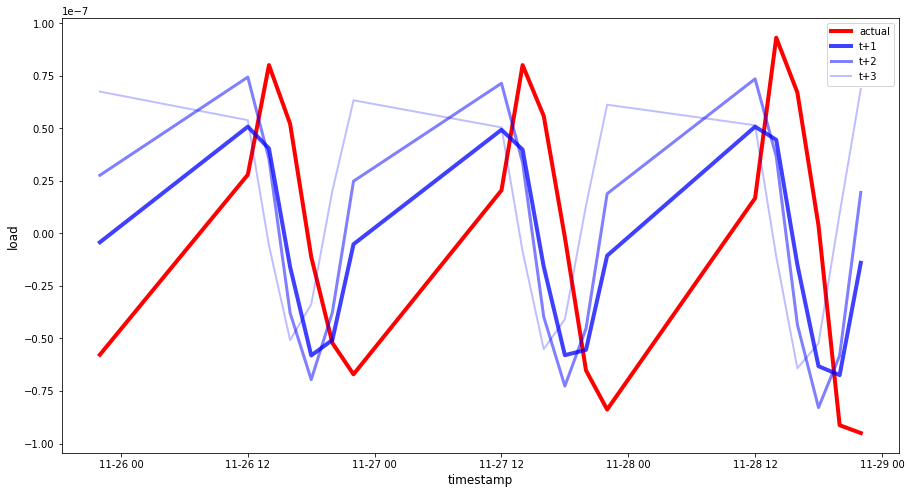

In [35]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [36]:
a = df.iloc[156:162  , :]
a

,Cic
Epoch_Time_of_Clock,
2017-11-28 12:00:00,-0.00000008381903171540
2017-11-28 14:00:00,0.00000001676380634310
2017-11-28 16:00:00,0.00000009313225746150
2017-11-28 18:00:00,0.00000006705522537230
2017-11-28 20:00:00,0.00000000372529029846
2017-11-28 22:00:00,-0.00000009126961231230


In [37]:
new_df = pd.DataFrame()

In [38]:
columns = [var_name] 

In [39]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [40]:
new_df = new_df.dropna( how = 'any')

In [41]:
new_df

,Cic
Epoch_Time_of_Clock,
2017-11-28 12:00:00,-0.00000008381903171540
2017-11-28 14:00:00,0.00000001676380634310
2017-11-28 16:00:00,0.00000009313225746150
2017-11-28 18:00:00,0.00000006705522537230
2017-11-28 20:00:00,0.00000000372529029846
2017-11-28 22:00:00,-0.00000009126961231230


In [42]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 29)

In [43]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [44]:
date

DatetimeIndex(['2017-11-29 12:00:00', '2017-11-29 14:00:00',
               '2017-11-29 16:00:00', '2017-11-29 18:00:00',
               '2017-11-29 20:00:00', '2017-11-29 22:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='2H')

In [45]:
new_df.index= date

In [46]:
new_df.columns

Index(['Cic'], dtype='object')

In [47]:
print(new_df)
print(new_df.columns)

                                        Cic
Epoch_Time_of_Clock                        
2017-11-29 12:00:00 -0.00000008381903171540
2017-11-29 14:00:00  0.00000001676380634310
2017-11-29 16:00:00  0.00000009313225746150
2017-11-29 18:00:00  0.00000006705522537230
2017-11-29 20:00:00  0.00000000372529029846
2017-11-29 22:00:00 -0.00000009126961231230
Index(['Cic'], dtype='object')


In [48]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                        Cic
Epoch_Time_of_Clock                        
2017-11-29 12:00:00 -0.66216455004438412590
2017-11-29 14:00:00  0.14550039350104623792
2017-11-29 16:00:00  0.75872748026629266427
2017-11-29 18:00:00  0.54933286527336000482
2017-11-29 20:00:00  0.04080308600425872068


In [49]:
print(new_new_df)
print(inputs['X'])

tensor                                    X                         \
feature                                 Cic                          
time step                               t-5                    t-4   
Epoch_Time_of_Clock                                                  
2017-11-29 22:00:00 -0.66216455004438412590 0.14550039350104623792   

tensor                                                             \
feature                                                             
time step                              t-3                    t-2   
Epoch_Time_of_Clock                                                 
2017-11-29 22:00:00 0.75872748026629266427 0.54933286527336000482   

tensor                                                              
feature                                                             
time step                              t-1                       t  
Epoch_Time_of_Clock                                                 
2017-11-29 22:00:00 0.04080

In [50]:
predictions = model.predict(inputs['X'])

In [51]:
predictions

array([[-0.101476885,  0.16757685 ,  0.5631385  ,  0.6630242  ,
         0.1285123  , -0.9795628  ]], dtype=float32)

In [52]:
print(predictions.shape)


(1, 6)


In [53]:
results = predictions[-1, :]

In [54]:
results

array([-0.101476885,  0.16757685 ,  0.5631385  ,  0.6630242  ,
        0.1285123  , -0.9795628  ], dtype=float32)

In [55]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,Cic
0,-0.10147688537836074829
1,0.16757684946060180664
2,0.56313848495483398438
3,0.66302418708801269531
4,0.12851229310035705566
5,-0.97956281900405883789


In [56]:
res_df.index = date
res_df

,Cic
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-0.10147688537836074829
2017-11-29 14:00:00,0.16757684946060180664
2017-11-29 16:00:00,0.56313848495483398438
2017-11-29 18:00:00,0.66302418708801269531
2017-11-29 20:00:00,0.12851229310035705566
2017-11-29 22:00:00,-0.97956281900405883789


In [57]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [58]:
# final generated ouput
res_df

,Cic
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-0.00000001399359650378
2017-11-29 14:00:00,0.00000001951310579784
2017-11-29 16:00:00,0.00000006877451141918
2017-11-29 18:00:00,0.00000008121381256387
2017-11-29 20:00:00,0.00000001464818666363
2017-11-29 22:00:00,-0.00000012334633936462


In [60]:
res_df.to_csv('SA1_Cic.csv')